### **EJEMPLO 2**
### Modelo Integrador (con base de datos)

In [1]:
from docplex.cp.model import *              # biblioteca de CP de DOCplex
import docplex.cp.utils_visu as visu        # biblioteca de visualización de DOCplex
import sqlite3                              # biblioteca de base de datos SQLITE 3

### PARÁMETROS

In [2]:
# Estos parámetros los debería traer directamente del m integrador de Gestión.

month = 10
year = 2024
horizon = 30                                # Horizonte de programación en días

### DATOS (EJEMPLO 2)

In [4]:
# Conexión a la base de datos

conexion=sqlite3.connect("integrador.db")

# Definición del calendario

c = conexion.execute(f"select fer_day from feriados where fer_month={month} and fer_year={year}")

feriados = [f[0] for f in c.fetchall()]

# Generación de función escalonada (calendario)

days = CpoStepFunction()

horizonte = horizon*24                      # pasaje del horizonte a horas

days.set_value(0, horizonte, 0)             # carga todas las horas al 0%

d = 0                                       # contador del número de días
s = 0                                       # contador de semana

horas_totales = 0                           # horas totales laborables (utilizado para los KPIs)

# prepara la semana de lunes a viernes al 100%

for j in range(0, horizonte, 24):
    if s<5:
        for k in range(j+8, j+17):
            days.set_value(k, k+1, 100)     
        days.set_value(j+12, j+13, 0)       # setea en cero la hora del almuerzo
        horas_totales += 8
    s = s + 1
    
    # setea los feriados
    d += 1
    if d in feriados:
        days.set_value(j, j+24, 0)          # el día feriado al 0%
        horas_totales -= 8
    
    if s == 7: s = 0

# obtiene una lista con los códigos de productos y otra con los colores de los productos que se fabrican

c = conexion.execute("select pro_code, pro_color from products where pro_fabrica=1;")

pr = c.fetchall()

prod = [p[0] for p in pr]
color_tipos = [p[1] for p in pr]

# obtiene una lista con los work center

c = conexion.execute("select woc_code from work_center")

tasks = [i[0] for i in c.fetchall()] 

# obtiene una lista con los colores

c = conexion.execute("select col_desc from colors")

colores = [i[0] for i in c.fetchall()] 

# genera la matriz de tiempos (para lavado en el WC de pintura)

c = conexion.execute("select cot_orig, cot_dest, cot_time from color_table order by cot_orig, cot_dest asc")

ct = c.fetchall()

cm = len(colores)

m_color = [[0 for i in range(cm)] for j in range(cm)]

for i in range(cm):
    for j in range(cm):
        m_color[i][j] = ct[i*cm+j][2]

matriz_color = transition_matrix(m_color)


### MODELO (Y MAS DATOS)

In [5]:
m = CpoModel()

ope = []

# genera los intervalos

operaciones = []        # lista de intervalos
tasks_idx = []
prod_idx = []

for p in prod:
    prod_idx.append(p)
 
    # obtiene los tiempos y work center para los intervalos
 
    c = conexion.execute(f"select prs_product, prs_workcenter, ((prs_time*sal_qty)/60) from process, sales where prs_product = '{p}' and prs_product = sal_product order by prs_prev asc")
    pr = c.fetchall()
    r = []
    t = []
    for i in pr:
        t.append(i[1])
        r.append(m.interval_var(
        size = int(i[2]), 
        name = i[0] + '_' + i[1], 
        intensity = days))   
    tasks_idx.append(t)        
    operaciones.append(r)

# genera las relaciones de precedencia

for p in range(len(prod)):
    
    # obtiene información sobre la operación anterior de cada operación para armar las secuencias

    c = conexion.execute(f"select p1.prs_product, p2.prs_workcenter, p1.prs_workcenter from process p1, process p2 where p1.prs_product = '{prod_idx[p]}' and p2.prs_product = '{prod_idx[p]}' and p1.prs_prev>0 and p2.prs_code = p1.prs_prev order by p1.prs_prev asc")
    pr = c.fetchall()
    
    for i in range(len(pr)):
        t1 = tasks_idx[p].index(pr[i][1])
        t2 = tasks_idx[p].index(pr[i][2])
        if prod_idx[p]+'_'+tasks_idx[p][i] == operaciones[p][i].name:
            m.add(m.end_before_start(operaciones[p][t1], operaciones[p][t2]))
        else:
            print('ERROR')      # se debería mejorar el manejo de errores en todo el modelo

# genera las limitaciones de cantidad de operarios para cada operación

for t in tasks:
    to = []
    for p in range(len(prod)):
        try:
            id = tasks_idx[p].index(t)
            if id>=0:
                to.append( operaciones[p][tasks_idx[p].index(t)] )
        except:
            None
    c = conexion.execute(f"select woc_employees from work_center where woc_code = '{t}';")
    em = c.fetchall()
    m.add(
        m.sum(
            m.pulse(o, 1) for o in to ) <= em[0][0]
    )

# establece la secuencia de pintura utilizando la tabla de lavado

seq_pintura = m.sequence_var([operaciones[p][tasks_idx[p].index('pintura')] for p in range(len(prod))], name='secuencia_pintura', types = color_tipos)

m.add(m.no_overlap(seq_pintura, matriz_color, True))

# genera el funcional

m.add( m.minimize(
        m.max(m.end_of(operaciones[p][tasks_idx[p].index('despacho')]) for p in range(len(prod)))
    )
)

### RESOLUCIÓN DEL m E IMPRESIÓN DE RESULTADOS

In [6]:
s = m.solve()

s.print_solution()

 ! --------------------------------------------------- CP Optimizer 22.1.0.0 --
 ! Minimization problem - 16 variables, 20 constraints
 ! Initial process time : 0.02s (0.03s extraction + 0.00s propagation)
 !  . Log search space  : 58.6 (before), 58.6 (after)
 !  . Memory usage      : 580.4 kB (before), 580.4 kB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         16                 -
 + New bound is 515
 ! Using iterative diving.
 *           610       31  0.05s        1      (gap is 15.57%)
             610       32         14    1   F        -
 + New bound is 610 (gap is 0.00%)
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! Best objective         : 610 (optimal - effective tol. is 0)
 ! Best bound             : 610
 ! --------------------

### GENERA GRÁFICOS

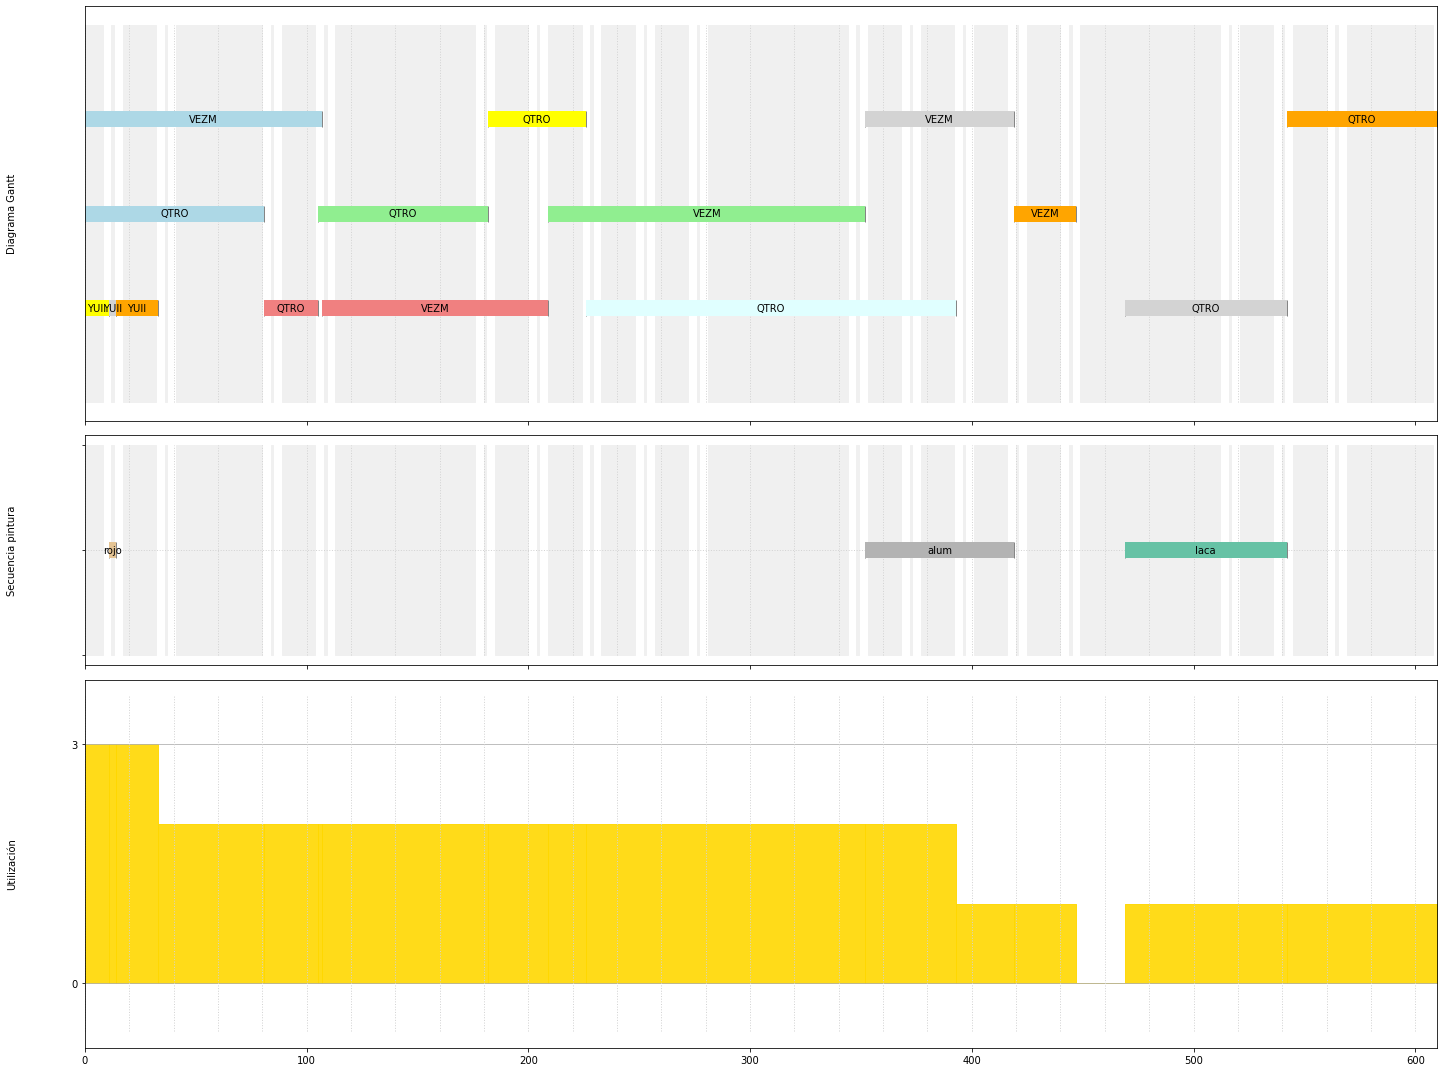

In [10]:
# obtiene los colores que identifica a cada operación

c = conexion.execute("select woc_color from work_center")

color = [p[0] for p in c.fetchall()]

# setea parámetros para el gráfico

from pylab import rcParams
rcParams['figure.figsize'] = 20, 15

# Genera el diagrama de gantt de operaciones

visu.panel(name='Diagrama Gantt')
visu.pause(days)                            # incluye el calendario
visu.naming(lambda name: name[0:4])  

for p in range(len(prod)):
    for o in operaciones[p]:
        if s.get_var_solution(o.name).size>0:
            visu.interval(s.get_var_solution(o.name), color[tasks.index(o.name[9:])], o.name)        


# Genera un gráfico con la secuenca de pintura

qq = s.get_var_solution(seq_pintura.name).get_interval_variables()
visu.panel(name='Secuencia pintura')
visu.pause(days) 

tip = [1, 2, 3] # punto de mejora !!!!!!

visu.sequence(name='',
              intervals=[(qq[q], color_tipos[q], colores[color_tipos[q]]) for q in range(len(qq))] 
              )

# Genera un gráfico de la utilización de operarios

visu.panel(name = 'Utilización')
utilizacion = CpoStepFunction()

for p in range(len(prod)):
    for o in operaciones[p]:
        utilizacion.add_value(s.get_var_solution(o.name).start, s.get_var_solution(o.name).end, 1)        

visu.function(segments=utilizacion, style='area', color='gold')

visu.show(horizon=200, origin=100, name='o', pngfile='r_sch_graph.png')     # genera un archivo

### ARCHIVO CSV (EJEMPLO 3)

In [ ]:
import pandas as pd
import datetime

d = datetime.datetime(year, month, 1)

n = 0

df = pd.DataFrame(columns=['Nro', 'Código', 'Descripción', 'Operación', 'Fecha inicio', 'Fecha fin', 'Tamaño [hs]',	'Duración [hs]', 'Pintura'])

for p in range(len(prod)):
    for o in operaciones[p]:
        if s.get_var_solution(o.name).size>0:
            sol = s.get_var_solution(o.name)
            n += 1
            c = conexion.execute(f"select pro_code, pro_desc, pro_painted, woc_desc from products, work_center where pro_code='{prod[p]}' and woc_code='{o.name[9:]}' and pro_fabrica=1")
            row = c.fetchall()
            paint='NO'
            if row[0][2]==1: paint='SI'            
            new = [n, row[0][0], row[0][1], '['+o.name[9:]+'] '+row[0][3], d+datetime.timedelta(hours=sol.start), d+datetime.timedelta(hours=sol.end), sol.size, sol.end-sol.start, paint]
            new = pd.DataFrame(columns=df.columns, data=[new])
            df = pd.concat([df, new], axis=0)
            
df.to_csv('r_scheduling.csv')

### FUNCION PARA GENERAR LAS REFERENCIAS DE COLORES
https://matplotlib.org/stable/gallery/color/named_colors.html

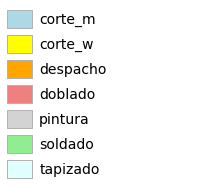

In [15]:
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

def plot_colortable(colors, *, ncols=4, sort_colors=True):

    cell_width = 200
    cell_height = 25
    swatch_width = 25
    margin = 12

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

plot_colortable({tasks[i]: color[i] for i in range(len(tasks))}, ncols=1, sort_colors=False).savefig('r_referencia.png')

### REPORTE (EJEMPLO 4)

In [15]:
# Genera los valores de los KPIS (Hay cosas hardcodeadas que no deberian estarlo ... es un punto de mejora)

a1 = (100*(df[df['Operación']=='[soldado] SOLDADO DE METAL']['Tamaño [hs]'].sum())/(horas_totales*2)) # soldado
a2 = (100*(df[df['Operación']=='[corte_w] CORTA DE MADERA']['Tamaño [hs]'].sum())/(horas_totales*2)) # corte de madera
a3 = (100*(df[df['Operación']=='[despacho] DESPACHO DE PRODUCTOS']['Tamaño [hs]'].sum())/(horas_totales*3)) # despacho

In [ ]:
from html import escape
from IPython.core.display import HTML

fecha = datetime.datetime.today()

html = f"""
<html>
  <head>
   <script type="text/javascript" src="https://www.gstatic.com/charts/loader.js"></script>
   <script type="text/javascript">
      google.charts.load('current', {{'packages':['gauge']}});
      google.charts.setOnLoadCallback(drawChart);

      function drawChart() {{

        var data1 = google.visualization.arrayToDataTable([
          ['Label', 'Value'],
          ['Soldado', {a1}]
        ]);

        var data2 = google.visualization.arrayToDataTable([
          ['Label', 'Value'],
          ['Corte de madera', {a2}]
        ]);

        var data3 = google.visualization.arrayToDataTable([
          ['Label', 'Value'],
          ['Despacho', {a3}]
        ]);

        var options = {{
          width: 180, height: 180,
          redFrom: 0, redTo: 10,
          yellowFrom:10, yellowTo: 60,
          minorTicks: 2
        }};

        var chart1 = new google.visualization.Gauge(document.getElementById('g1'));

        chart1.draw(data1, options);

        var chart2 = new google.visualization.Gauge(document.getElementById('g2'));

        chart2.draw(data2, options);

        var chart3 = new google.visualization.Gauge(document.getElementById('g3'));

        chart3.draw(data3, options);

      }}
    </script>
  </head>
  <body>
    <div id="1" style="width: 100%; height: 50px;"><p style="text-align: right;font-family:verdana;"  >{fecha.date()}</p></div>
    <div id="2" style="width: 100%; height: 50px;"><h3 style="text-align: center;font-family:verdana;">m INTEGRADOR DE SCHEDULING</h3></div>
    <div id="3" style="width: 100%; height: 1080px;"><img src="r_sch_graph.png" style="display: block;margin-left: auto;margin-right: auto;width: 90%;" /></div>
    <div id="4" style="width: 300px; height: 300px;margin-left: 80px;"><img src="r_referencia.png" style="display: block;margin-left: auto;margin-right: auto;width: 60%;" /></div>
    
    <div style="content: '';display: table;clear: both;width: 80%;margin-left: auto;margin-right: auto;">
      <div id="g1" style="float: left;width: 33.33%;">
      </div>
      <div id="g2" style="float: left;width: 33.33%;">
      </div>
      <div id="g3" style="float: left;width: 33.33%;">
      </div>
    </div>
  </body>
</html>
"""

# Graba el HTML

with open("r_scheduling.html", "w") as f:
    f.write(html)

In [18]:
# Genera el PDF

import os
from pyhtml2pdf import converter

path = os.path.abspath('r_scheduling.html')
converter.convert(f'file:///{path}', 'r_scheduling.pdf')